In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor

In [128]:
train_df = pd.read_csv('SUBMISSION/Data Files/train_data.csv')
train_df.replace(-1.0, np.nan, inplace=True)
train_df.replace('-1', np.nan, inplace=True)

In [129]:
train_df.columns

Index(['brand', 'che_pc_usd', 'che_perc_gdp', 'cluster_nl', 'corporation',
       'country', 'launch_date', 'date', 'drug_id', 'ind_launch_date',
       'indication', 'insurance_perc_che', 'population', 'prev_perc',
       'price_month', 'price_unit', 'public_perc_che', 'therapeutic_area',
       'target'],
      dtype='object')

In [130]:
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
numeric_cols

Index(['che_pc_usd', 'che_perc_gdp', 'insurance_perc_che', 'population',
       'prev_perc', 'price_month', 'price_unit', 'public_perc_che', 'target'],
      dtype='object')

In [131]:
train_df.isna().sum()

brand                     0
che_pc_usd              741
che_perc_gdp           3644
cluster_nl                0
corporation               0
country                   0
launch_date               0
date                      0
drug_id                   0
ind_launch_date       87797
indication                0
insurance_perc_che    23190
population                0
prev_perc                 0
price_month           24152
price_unit              239
public_perc_che         741
therapeutic_area          0
target                    0
dtype: int64

In [132]:
train_df.shape

(118917, 19)

In [133]:
categorical_columns = ['brand', 'corporation', 'country', 'therapeutic_area', 'indication']
for col in categorical_columns:
    print(f"Column: {col}")
    print(train_df[col].value_counts())
    print("\n")

Column: brand
brand
BRAND_0056    2366
BRAND_62C7    1875
BRAND_7A2E    1762
BRAND_A12A    1761
BRAND_4048    1642
              ... 
BRAND_68E1       1
BRAND_0417       1
BRAND_47A8       1
BRAND_E02F       1
BRAND_ECB8       1
Name: count, Length: 591, dtype: int64


Column: corporation
corporation
CORP_01C7    19445
CORP_5CBD     9004
CORP_C868     7771
CORP_8F4F     6502
CORP_A713     5879
             ...  
CORP_7527       12
CORP_3573        2
CORP_F9A9        1
CORP_2F56        1
CORP_FE01        1
Name: count, Length: 136, dtype: int64


Column: country
country
COUNTRY_907E    5522
COUNTRY_3AD0    5002
COUNTRY_89F9    4811
COUNTRY_53A5    4782
COUNTRY_D8B0    4654
COUNTRY_445D    4547
COUNTRY_4242    4425
COUNTRY_1007    4119
COUNTRY_9891    3891
COUNTRY_6F78    3810
COUNTRY_0309    3760
COUNTRY_B6AE    3654
COUNTRY_D5B9    3486
COUNTRY_4442    3345
COUNTRY_06E4    3260
COUNTRY_8DBB    3236
COUNTRY_221C    3216
COUNTRY_FA79    3183
COUNTRY_4253    3169
COUNTRY_EA71    3049
COUN

In [134]:
train_df['price_month'].describe() 

count    94765.000000
mean         1.399850
std          1.158043
min          1.000000
25%          1.007002
50%          1.121036
75%          1.458762
max         39.343041
Name: price_month, dtype: float64

In [135]:
# numerical_columns = ['che_pc_usd', 'che_perc_gdp', 'price_month', 'price_unit', 'public_perc_che', 'insurance_perc_che', 'population', 'prev_perc', 'target']
# for col in numerical_columns:
#     plt.figure(figsize=(8, 4))
#     sns.histplot(train_df[col].dropna(), kd=True)
#     plt.title(f'Distribution of {col}')
#     plt.show()

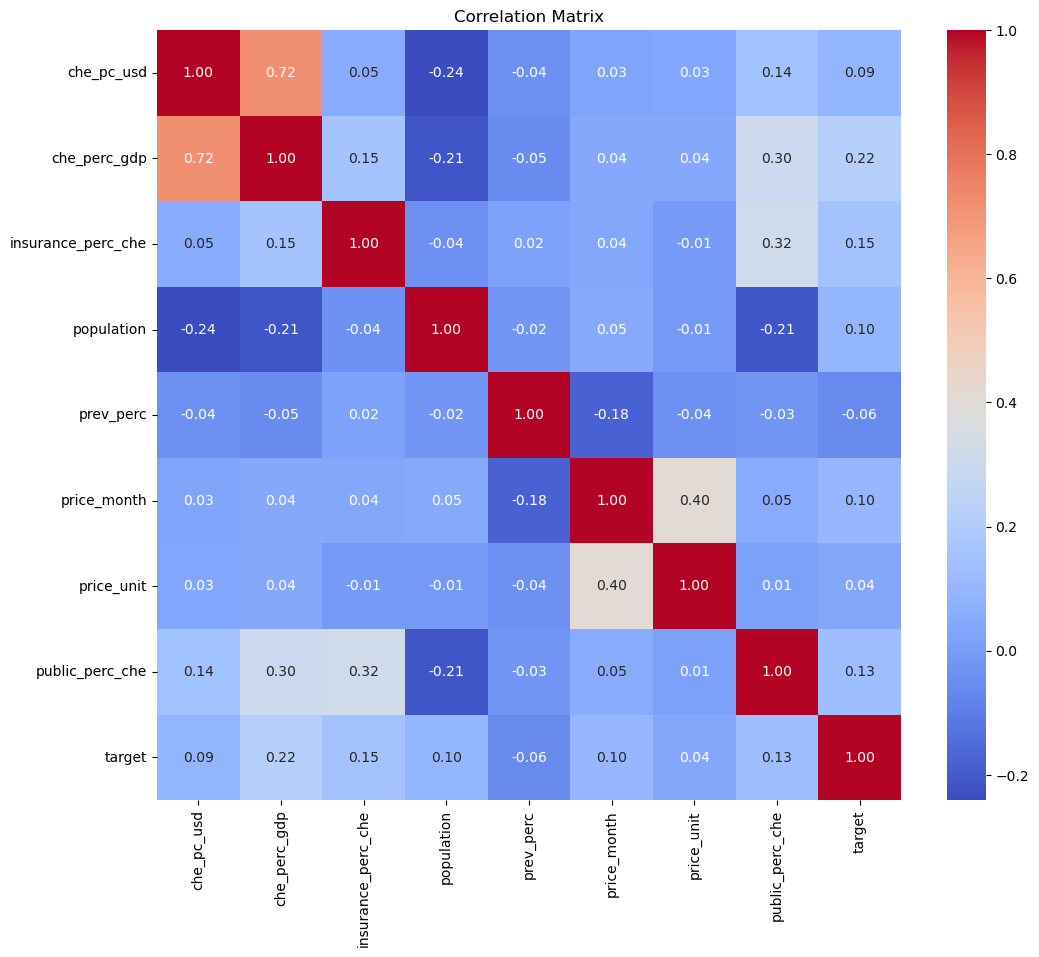

In [136]:
plt.figure(figsize=(12, 10))
corr_matrix = train_df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [137]:
train_df[numeric_cols] = train_df[numeric_cols].fillna(train_df[numeric_cols].median())

In [138]:
date_columns = ['launch_date', 'date', 'ind_launch_date']
for col in date_columns:
    train_df[col] = pd.to_datetime(train_df[col], errors='coerce')

In [139]:
train_df['launch_year'] = train_df['launch_date'].dt.year
train_df['launch_month'] = train_df['launch_date'].dt.month
train_df['date_year'] = train_df['date'].dt.year
train_df['date_month'] = train_df['date'].dt.month

In [140]:
from sklearn.preprocessing import LabelEncoder
label_enc_columns = ['brand', 'corporation', 'country', 'therapeutic_area', 'drug_id']
label_encoders = {}
for col in label_enc_columns:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    label_encoders[col] = le

In [141]:
train_data = train_df[train_df['date'] < '2022-01-01']
test_data = train_df[train_df['date'] >= '2022-01-01']

In [142]:
X_train = train_df.drop(['target', 'cluster_nl', 'launch_date', 'date', 'ind_launch_date', 'indication'], axis=1)
# X_train = train_data.drop(['target', 'launch_date', 'date', 'ind_launch_date', 'indication'], axis=1)
y_train = train_df['target']

X_test = test_data.drop(['target', 'cluster_nl', 'launch_date', 'date', 'ind_launch_date', 'indication'], axis=1)
# X_test = test_data.drop(['target', 'launch_date', 'date', 'ind_launch_date', 'indication'], axis=1)
y_test = test_data['target']

In [143]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [144]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [145]:
model = XGBRegressor(n_estimators=400, n_jobs=-1, random_state=33)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=-1,
             num_parallel_tree=None, random_state=33, ...)

In [146]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error: 0.0159
R² Score: 0.9932


### Create submission

In [147]:
test_df = pd.read_csv('SUBMISSION/Data Files/submission_data.csv')
test_df.replace(-1.0, np.nan, inplace=True)
test_df.replace('-1', np.nan, inplace=True)

In [148]:
test_df[numeric_cols] = test_df[numeric_cols].fillna(test_df[numeric_cols].median())

In [149]:
date_columns = ['launch_date', 'date', 'ind_launch_date']
for col in date_columns:
    test_df[col] = pd.to_datetime(test_df[col], errors='coerce')

In [150]:
test_df['launch_year'] = test_df['launch_date'].dt.year
test_df['launch_month'] = test_df['launch_date'].dt.month
test_df['date_year'] = test_df['date'].dt.year
test_df['date_month'] = test_df['date'].dt.month

In [151]:
for col in label_enc_columns:
    le = label_encoders[col]
    test_df[col] = le.fit_transform(test_df[col].astype(str))
    label_encoders[col] = le

In [152]:
X_test = test_df.drop(['target', 'cluster_nl', 'launch_date', 'date', 'ind_launch_date', 'indication'], axis=1)

In [153]:
y_pred = model.predict(X_test)

In [ ]:
test_df['date_str'] = test_df['date'].astype(str)

In [163]:
submission_data = pd.DataFrame({'date_str':test_df['date_str'], 'cluster_nl':test_df['cluster_nl'], 'prediction': y_pred})

In [167]:
submission_csv = pd.read_csv('SUBMISSION/submission_template.csv')

In [168]:
submission_csv.drop('prediction', axis=1, inplace=True)

In [169]:
submission_csv['date']

0       2023-01-01
1       2023-02-01
2       2023-03-01
3       2023-04-01
4       2023-05-01
           ...    
1764    2023-08-01
1765    2023-09-01
1766    2023-10-01
1767    2023-11-01
1768    2023-12-01
Name: date, Length: 1769, dtype: object

In [170]:
submission_csv = pd.merge(submission_csv, submission_data, left_on=['date', 'cluster_nl'], right_on=['date_str', 'cluster_nl'], how='left')

In [171]:
submission_csv

,date,cluster_nl,date_str,prediction
0,2023-01-01,BRAND_9259_COUNTRY_6B71,2023-01-01,0.951238
1,2023-02-01,BRAND_9259_COUNTRY_6B71,2023-02-01,0.955303
2,2023-03-01,BRAND_9259_COUNTRY_6B71,2023-03-01,0.917630
3,2023-04-01,BRAND_9259_COUNTRY_6B71,2023-04-01,0.956023
4,2023-05-01,BRAND_9259_COUNTRY_6B71,2023-05-01,0.959714
...,...,...,...,...
1764,2023-08-01,BRAND_056A_COUNTRY_3536,2023-08-01,0.885207
1765,2023-09-01,BRAND_056A_COUNTRY_3536,2023-09-01,0.917031
1766,2023-10-01,BRAND_056A_COUNTRY_3536,2023-10-01,0.889802
1767,2023-11-01,BRAND_056A_COUNTRY_3536,2023-11-01,0.870075


In [ ]:
submission_csv.drop('date_str', axis=1, inplace=True)

In [176]:
submission_csv.to_csv('submission_0.csv', index=False)